# Clase 7: Minería de texto
En esta clase vamos a ver el tratamiento básico de texto, expresiones regulares, un modelo de tópicos __Latent Dirichlet Allocation (LDA)__.

Cubriremos los siguientes temas:
* Tratamiento de textos
* Preprocesamiento de textos
* WordClouds
* Document-Term Matrix
* LDA
* Interpretación de resultados
    * Palabras más importantes
    * Distribución de textos por tópicos
* Selección de modelo
* Visualización (LDAvis)

Para estudiar LDA, a parte del paper original, les recomendamos el siguiente video: https://www.youtube.com/watch?v=3mHy4OSyRf0&t=6s

La base de datos que trabajaremos será una muestra de noticias de [Reuters](https://www.reuters.com/) obtenida a través de webscrapping por Germán González.

1. ¿Qué significa que un problema sea de análisis no supervisado?
2. ¿Cómo evalúo uno de estos modelos?
3. ¿Que son datos no estructurados?
4. ¿Cómo entiende un computador los datos no estructurados?


In [1]:
import pandas as pd 
import re # El paquete para tratar texto. Expresiones regulares
from sklearn.feature_extraction.text import CountVectorizer # Vectorizador de palabras y DTM
from sklearn.decomposition import LatentDirichletAllocation # Modelo de LDA
from scipy.sparse import csr_matrix # Para tratar Sparse Matrix
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data=pd.read_csv('reuters.csv') # CArgo los datos

In [3]:
data.head()

,Url,Fecha_Noticia,Titulo,Noticia
0,https://www.reuters.com/article/ceconomy-resul...,2019-02-08 09:16:39+00:00,UPDATE 2-Germany's Ceconomy shares jump 20 pct...,"* Q1 sales rise 1.7 pct to 6.9 bln euros, ahea..."
1,https://www.reuters.com/article/china-stocks-c...,2019-01-02 07:20:55+00:00,China stocks end lower as economic data disapp...,"* Shanghai index ends lower, blue-chip CSI300 ..."
2,https://www.reuters.com/article/safrica-pic-tr...,2019-02-01 15:55:43+00:00,South Africa's finance minister to name interi...,"JOHANNESBURG, Feb 1 (Reuters) - South Africa’s..."
3,https://www.reuters.com/article/sophos-group-s...,2019-01-18 10:06:12+00:00,UPDATE 1-Sophos shares tank as demand for cybe...,"(Adds CEO, analyst comments; Updates share pri..."
4,https://www.reuters.com/article/britain-eu-ame...,2019-01-29 20:35:31+00:00,UPDATE 1-UK parliament backs amendment urging ...,(Edits headline to make clearer that amendment...


In [4]:
data.Noticia.iloc[25] # Exploro una noticia

'NEW YORK (Reuters) - The dollar slid and equities surged on Wednesday, fueled by Boeing and Apple’s results and extended after the Federal Reserve pledged to be patient with future interest rate hikes, a change in tone that stock investors interpreted as a buy signal.\r\n\r\nA trader works at his desk at the stock exchange in Frankfurt, Germany, January 30, 2019. REUTERS/Staff\r\n\r\nThe Fed, in its policy statement at the end of a two-day meeting, struck the language from its December policy statement that indicated further rate hikes would be appropriate in 2019. That language had roiled markets amid signs of slower global growth.\r\n\r\nU.S. stocks extended gains and bond yields fell as markets got what they were hoping for, said Mohamed El-Erian, chief economic adviser at Allianz in Newport Beach, California. “This marks a full 180 from what the Fed was signaling just a few months ago,” he said.\r\n\r\nScott Minerd, global chief investment officer at Guggenheim Partners in Santa M

## Preprocesamiento
* Tokenizar: Separar el texto en párrafos, frases, etc...
* Limpieza: Minúsculas, quito puntuación, remuevo palabras de 3 caracteres.
* Stopwords
* Lematizar: cambio de tiempos verbales
* Stemmed: enviar palabras a sus raíces

## Limpieza básica
Para ver más sobre expresiones regulares vea: https://www.w3schools.com/python/python_regex.asp

Puede practicar en: https://regex101.com/

In [5]:
set(re.findall('f[a-z]+', data.Noticia.iloc[25])) # Busco las palabras que comienzan por f

{'fell',
 'few',
 'ff',
 'fficer',
 'filled',
 'financial',
 'first',
 'fit',
 'flected',
 'flow',
 'following',
 'for',
 'forecasts',
 'foreign',
 'formance',
 'fornia',
 'from',
 'fted',
 'ften',
 'fter',
 'fueled',
 'full',
 'fundamentally',
 'furt',
 'further',
 'future',
 'futures'}

### Ejercicios
Extraiga de una noticia cualquiera lo siguiente:
1. Los números. (piense en los decimales)
2. Los número que correspondan a porcentajes (vea la palabra percent).
4. Todas la palabras que comiencen por Mayúscula.
5. Todas la palabras que comiencen por Mayúscula pero el resto de caracteres estén en minúscula.
5. Extraiga todas las palabras que inicien por `r` (mayúscula o minúscula).

In [6]:
set(re.findall('[0-9\.]+', data.Noticia.iloc[25]))
set(re.findall('[0-9\.]+ percent', data.Noticia.iloc[25]))
set(re.findall('[A-Z][a-z]+', data.Noticia.iloc[25]))
set(re.findall('[A-Z][A-z]+', data.Noticia.iloc[25]))
set(re.findall('[rR][A-z]+', data.Noticia.iloc[25]))

{'REUTERS',
 'RK',
 'Reserve',
 'Reuters',
 'racks',
 'rader',
 'rage',
 'raised',
 'ral',
 'rankfurt',
 'rate',
 'ravel',
 'rcent',
 'rcome',
 'rd',
 're',
 'reasing',
 'reassurance',
 'reasury',
 'recasts',
 'rector',
 'refilled',
 'reflected',
 'reign',
 'rejected',
 'relief',
 'remain',
 'rent',
 'reported',
 'res',
 'rest',
 'results',
 'revent',
 'revenue',
 'rexit',
 'rformance',
 'rge',
 'rged',
 'rgest',
 'ri',
 'rial',
 'rian',
 'rice',
 'rices',
 'ries',
 'rilla',
 'rillion',
 'ring',
 'risk',
 'risks',
 'ritish',
 'rivate',
 'rk',
 'rket',
 'rkets',
 'rks',
 'rld',
 'rled',
 'rliament',
 'rliamentary',
 'rling',
 'rly',
 'rm',
 'rmany',
 'rmediate',
 'rn',
 'rnational',
 'rnia',
 'rnight',
 'ro',
 'road',
 'rocessor',
 'roduction',
 'rofirst',
 'rofit',
 'roiled',
 'rokerage',
 'rolls',
 'rom',
 'room',
 'rop',
 'rope',
 'ropean',
 'roposal',
 'ropriate',
 'rose',
 'rovided',
 'rowth',
 'rp',
 'rply',
 'rpreted',
 'rrel',
 'rrency',
 'rs',
 'rt',
 'rter',
 'rther',
 'rtion'

In [7]:
## Limpieza.
### Se usa los métodos de pandas que provienen de .str
#for i in range(len(data.Noticia)):
    #data.Noticia.iloc[i]=re.sub('[,\.!?\-!?\n\)\(\r]', '',data.Noticia.iloc[i]) 
    #data.Noticia.iloc[i]=re.sub('[0-9]', '',data.Noticia.iloc[i]) 
   # data.Noticia.iloc[i]=re.sub('reuters', '',data.Noticia.iloc[i]) 
   # data.Noticia.iloc[i]=re.sub('said', '',data.Noticia.iloc[i]) # Quito la palabra said
data.Noticia=data.Noticia.str.lower() 
data.Noticia=data.Noticia.str.replace('[,\.!?\-!?\n\)\(\r]', ' ') # Borro Puntuaciones
data.Noticia=data.Noticia.str.replace('[0-9]', ' ') # Quito números
data.Noticia=data.Noticia.str.replace('reuters', '')# Quito la palabra reuters
data.Noticia=data.Noticia.str.replace('  +', ' ')
data.Noticia=data.Noticia.str.replace('said', '') # Convierto minúsculas

In [8]:
data.Noticia.iloc[25] # Volvemos a ver la misma noticia

'new york the dollar slid and equities surged on wednesday fueled by boeing and apple’s results and extended after the federal reserve pledged to be patient with future interest rate hikes a change in tone that stock investors interpreted as a buy signal a trader works at his desk at the stock exchange in frankfurt germany january /staff the fed in its policy statement at the end of a two day meeting struck the language from its december policy statement that indicated further rate hikes would be appropriate in that language had roiled markets amid signs of slower global growth u s stocks extended gains and bond yields fell as markets got what they were hoping for  mohamed el erian chief economic adviser at allianz in newport beach california “this marks a full from what the fed was signaling just a few months ago ” he  scott minerd global chief investment officer at guggenheim partners in santa monica california  the fed’s pause will further extend the economic expansion allowing exce

In [9]:
# Ahora construiremos la matriz término-documento
n_vocab=1500 # máximo tamaño de vocabulario
tf_vectorizer = CountVectorizer(max_df=0.8, min_df=2, max_features=n_vocab, stop_words='english', ngram_range=(1,3)) # Al igual que un modelo, defino el objeto que construirá la matriz
tf = tf_vectorizer.fit_transform(data.Noticia) # Aplico el objeto a un conjunto de textos
tf_feature_names = tf_vectorizer.get_feature_names() # Veo el vocabulario

In [10]:
# Exploremos los stopwords
tf_vectorizer.get_stop_words()

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

In [11]:
TF_detallada=pd.DataFrame(csr_matrix(tf).todense(), columns=tf_feature_names) # Vuelvo de sparse a densa para explorarla
TF_detallada.head() #Veo las primeras 5 filas
print(TF_detallada.shape) # Veo las dimensiones, a qué corresponden?

(2000, 1500)


In [12]:
TF_detallada.head() # Exploramos la matriz término-documento

,able,abu,abuse,access,according,account,accounts,accused,acquire,act,...,years,years ago,yemen,yen,yield,yields,york,young,yuan,zone
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [13]:
data.Noticia.iloc[0] # Cuántas veces aparece years?

'* q sales rise pct to bln euros ahead of poll * q ebitda hit by mln in costs for management overhaul * online sales up pct to break bln euro mark adds quotes from cfo shares analyst details by caroline copley berlin feb shares in ceconomy surged more than percent on friday after europe’s biggest consumer electronics retailer posted better than expected sales for its first quarter buoyed by black friday discount days and upbeat online sales ceconomy which runs more than media markt and saturn stores across europe has faced fierce competition from amazon com and other online outlets prompting a string of profit warnings last year that led to the departure of its top management team the retailer has been trying to better integrate its stores and online range and  an improved management of black friday when customers placed million orders online boosted sales in the its fiscal first quarter from october to december revenues for the period rose percent to billion euros $ billion topping th

In [14]:
# ¿Que tal si estudiamos las frecuencias de las palabras?
frecuencias=pd.DataFrame(TF_detallada.sum(), index=tf_feature_names, columns=['Freq'])
frecuencias.sort_values(by=['Freq'], ascending=False, inplace=True)
frecuencias.head(15)

,Freq
percent,3424
year,2406
new,1551
government,1269
million,1121
billion,1108
china,1105
company,1095
points,1026
jan,1005


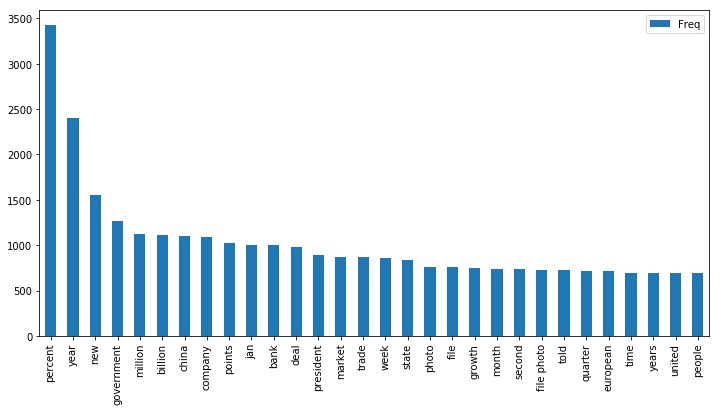

In [15]:
frecuencias.head(30).plot(kind='bar', figsize=(12,6))

In [16]:
!pip install wordcloud

In [17]:
from wordcloud import WordCloud #importo la función

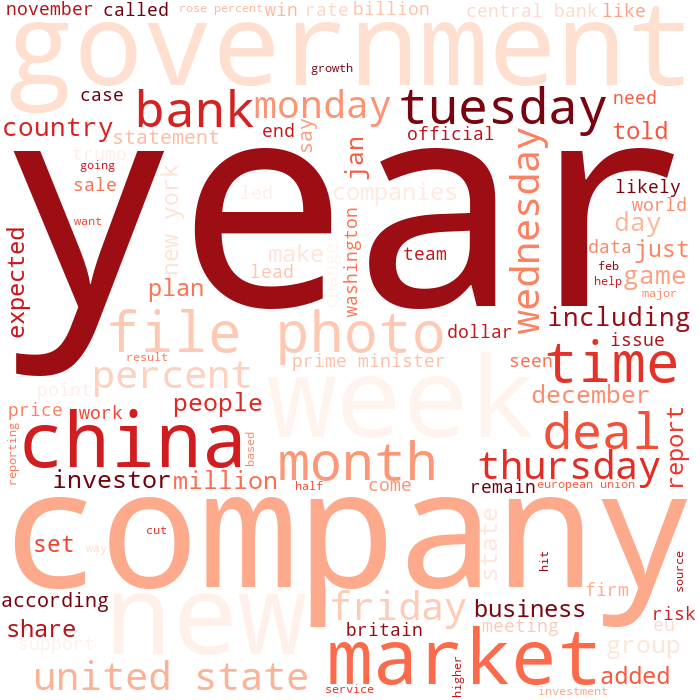

In [18]:
cloud=WordCloud(background_color='white', width=700, height=700, max_words=100, max_font_size=300, stopwords=tf_vectorizer.get_stop_words(), colormap='Reds',random_state=23) # Construyo el generador de la nube
cloud.generate('.'.join(list(data.Noticia))) # Genero la nube
cloud.to_image() # Despliego la imagen de la nube
# Para ver las gamas de colores vea: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
# Para ver más parámetros de la nube de palabras: https://amueller.github.io/word_cloud/auto_examples/index.html#example-gallery

## Modelo LDA

In [19]:
num_topics=10 # Cuántos tópicos deseo
lda = LatentDirichletAllocation(n_components=num_topics, max_iter=10,doc_topic_prior=0.1, topic_word_prior=0.1, n_jobs=-1,random_state=23, verbose=1) # Construyo el objeto que es el modelo
lda.fit(tf) # Estimo el LDA

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


LatentDirichletAllocation(batch_size=128, doc_topic_prior=0.1,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=-1,
                          perp_tol=0.1, random_state=23, topic_word_prior=0.1,
                          total_samples=1000000.0, verbose=1)

In [20]:
print(lda.components_.shape) # De que tma~no es el resultado?
lda.components_ # Exploremos el resultado

(10, 1500)


array([[ 9.40791565,  0.100021  ,  0.10000036, ..., 16.35541299,
         0.10000003, 22.63969358],
       [13.90324622,  0.10000451,  0.10001376, ...,  0.10000821,
         0.10000097,  0.64772573],
       [34.93835627,  0.10001148,  0.10000414, ...,  0.10001154,
         0.10000323,  0.10001004],
       ...,
       [ 7.75973725,  8.52015383,  0.10000524, ...,  7.09310671,
         0.10000182, 11.5066145 ],
       [ 0.10001695,  0.10001237,  0.10000151, ...,  0.1000059 ,
        70.75433669,  0.10780222],
       [ 0.10002846, 34.16880877,  0.1000001 , ...,  1.25721532,
         7.6533227 ,  5.71728094]])

In [21]:
# Construyo la función que me ayuda a ver las palabras más importantes de cada tópico
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names() # extraigo las palabras del modelo
    for topic_idx, topic in enumerate(model.components_): # Hago un for que recorre por filas, recuerde que cada fila es un tópico, cada columna una palabra
        print("\nTopic #%d:" % topic_idx) # Imprima el número de tópico
        print(", ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]])) #Muestre las n palabras más importantes por orden 

In [22]:
print_topics(lda, tf_vectorizer, 15) # Veo las 15 palabras más importantes de cada tópico


Topic #0:
points, game, scored, second, lead, season, goal, field, left, point, win, games, half, play, just

Topic #1:
brexit, britain, deal, eu, european, minister, parliament, prime, prime minister, london, british, union, government, european union, party

Topic #2:
company, million, new, percent, business, billion, companies, year, file, photo, deal, market, file photo, group, years

Topic #3:
percent, year, billion, quarter, million, profit, shares, company, earnings, revenue, rose, growth, fourth, sales, new

Topic #4:
bank, banks, billion, year, india, government, new, state, financial, germany, file, file photo, central, photo, told

Topic #5:
percent, year, growth, dollar, trade, markets, economy, rate, economic, market, data, global, month, bank, week

Topic #6:
people, court, year, told, government, new, police, state, years, case, judge, rights, women, did, according

Topic #7:
trump, president, washington, united, states, united states, government, house, venezuela, dona

In [23]:
# Como se ven los documentos?
lda_output=lda.transform(tf) # transformo la matrix de término-documento en tópico-documento
print(lda_output.shape) # Qué indican las dimensiones?
docs=['doc'+str(i) for i in range(lda_output.shape[0])] # Nombres de filas
topics=['topics'+str(i) for i in range(lda_output.shape[1])] # Nombres de columnas
lda_output=pd.DataFrame(lda_output, index=docs, columns=topics)

(2000, 10)


In [24]:
# Exploremos la salida desde el punto de vista de documentos
lda_output.head().sum(axis=1) # Porque las filas suman 1?


doc0    1.0
doc1    1.0
doc2    1.0
doc3    1.0
doc4    1.0
dtype: float64

In [25]:
# Cómo se distribuye el documento promedio?
lda_output.head().mean(axis=0)

topics0    0.011615
topics1    0.197788
topics2    0.099313
topics3    0.272851
topics4    0.189299
topics5    0.087246
topics6    0.009172
topics7    0.001297
topics8    0.027620
topics9    0.103797
dtype: float64

In [26]:
# Creemos la pertenencia al tópicos
topico_dominante = np.argmax(lda_output.values, axis=1) 
lda_output['Topico_dominante']=topico_dominante
lda_output.head(10)

,topics0,topics1,topics2,topics3,topics4,topics5,topics6,topics7,topics8,topics9,Topico_dominante
doc0,0.042034,0.000513,0.159969,0.745439,0.049481,0.000513,0.000513,0.000513,0.000513,0.000513,3
doc1,0.000568,0.000568,0.000568,0.000568,0.000568,0.430313,0.000568,0.000568,0.052641,0.513068,9
doc2,0.002942,0.002942,0.002942,0.002942,0.893980,0.002942,0.002942,0.002942,0.082484,0.002942,4
doc3,0.010779,0.000709,0.331333,0.613551,0.000709,0.000709,0.040081,0.000709,0.000709,0.000709,3
doc4,0.001755,0.984209,0.001755,0.001754,0.001755,0.001754,0.001755,0.001755,0.001755,0.001755,1
doc5,0.002779,0.002779,0.756655,0.221117,0.002779,0.002778,0.002779,0.002778,0.002779,0.002778,2
doc6,0.001075,0.123662,0.001076,0.001075,0.001075,0.001075,0.867734,0.001076,0.001075,0.001076,6
doc7,0.000490,0.040057,0.000490,0.000490,0.000490,0.884316,0.000490,0.055057,0.000490,0.017627,5
doc8,0.000863,0.000862,0.000862,0.000862,0.000862,0.000862,0.921458,0.050013,0.000862,0.022493,6
doc9,0.001854,0.001852,0.001852,0.001852,0.160777,0.001852,0.761663,0.064594,0.001852,0.001852,6


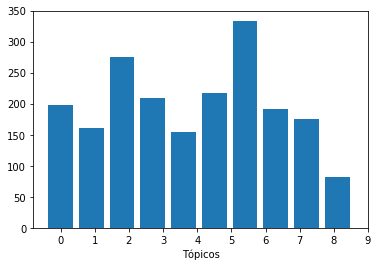

In [27]:
plt.hist(lda_output.Topico_dominante, density=False, rwidth=0.8, align='left')
plt.xlabel('Tópicos')
plt.xticks(range(num_topics));

## Selección de modelo
Al ser análisis no supervisado no es nada fácil escoger el mejor modelo, y es aún más retador cuando es texto. Tenemos una aproximación, la máxima verosimilitud

In [28]:
%%time
# Juguemos con un hiper parámetro
likelihood=[]
values=[i for i in range(2,31,2)]
for i in values:
    modelo = LatentDirichletAllocation(n_components=i, max_iter=10,doc_topic_prior=0.1, topic_word_prior=0.1, n_jobs=-1,random_state=23) # Construyo el objeto que es el modelo
    modelo.fit(tf)
    likelihood.append(modelo.score(tf))
    print(i)

2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
Wall time: 1min 7s


Text(0, 0.5, 'log-likelihood')

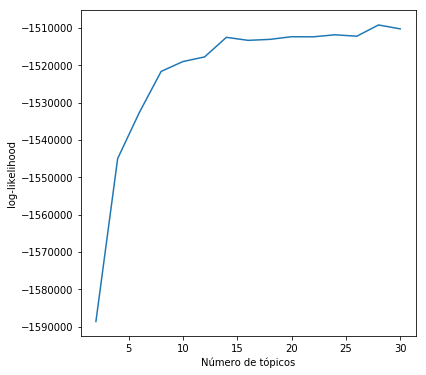

In [29]:
# Visualizamos
plt.figure(figsize=(6,6))
plt.plot(values, likelihood)
plt.xlabel('Número de tópicos')
plt.ylabel('log-likelihood')

## Visualización del LDA
LDAvis es un paquete para la visualización para interpretar más fácilmente el LDA. Vea el paper [aquí](https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf), en este agregan un nuevo parámetro para la interpretació, $\lambda \in [0,1]$, el cual pondera la importancia de una palabra dentro del tópico por la unicidad de la palabra a lo largo de los tópicos. 
* $\lambda\rightarrow1$: este es el caso original, permite que la palabra sea repetida a lo largo de los tópicos.
* $\lambda\rightarrow0$: este caso cambia el rqanking de importancia, dándole mayor importancia a las palabras que sean únicas del tópico, es decir que no aparezcan casi en los demás.


In [30]:
!pip install pyLDAvis

In [31]:
import pyLDAvis # Paquete que crea la visualización
from pyLDAvis import sklearn as sklearnlda

In [32]:
LDAvis_prepared=sklearnlda.prepare(lda, tf, tf_vectorizer ) # Preparo el modelo y sus resultados para la visualización
pyLDAvis.save_html(LDAvis_prepared, 'LDA.html') # Guardo la visualización como html

C:\Users\jsmor\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [33]:
pyLDAvis.display(LDAvis_prepared) # Lo visualizo dentro del notebook